In [1]:
import sys
import time
from os import listdir
from os.path import isfile, join
import string
import numpy as np
from sklearn.linear_model import LogisticRegression as LR
from nltk.stem.lancaster import LancasterStemmer
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import EnglishStemmer
from collections import OrderedDict
import pandas as pd
from nltk.corpus import stopwords

In [2]:
#import nltk
#nltk.download()

In [3]:
def get_file_names(path):
    return [path + "/" + f for f in listdir(path) if isfile(join(path, f))]

In [4]:
def file_to_tokens(file_name):#, min_word_size, stemmer=None):
    with open(file_name) as f:
        file_string = f.read().rstrip()
       # print(len(file_string))
        '''
    tokens = remove_punct(file_string).split()
    tokens = remove_stop_and_short_words(tokens, min_word_size)
    if stemmer:
        return stem_tokens(tokens, stemmer)
    else:
    '''
        return file_string
        #return tokens

In [5]:
def text_process(mess):
    """
    Takes in a string of text, then performs the following:
    1. Remove all punctuation
    2. Remove all stopwords
    3. Returns a list of the cleaned text
    """
    # Check characters to see if they are in punctuation
    nopunc = [char for char in mess if char not in string.punctuation]

    # Join the characters again to form the string.
    nopunc = ''.join(nopunc)
    
    # Now just remove any stopwords
    return ' '.join([word for word in nopunc.split() if word.lower() not in stopwords.words('english')])

In [6]:
def build_data(pos_file_path, neg_file_path ):
    pos_file_names = get_file_names(pos_file_path)
    neg_file_names = get_file_names(neg_file_path)
    # m is the number of training examples
    m_pos = len(pos_file_names)
    m_neg = len(neg_file_names)
    m = m_pos + m_neg
    pos_labels = np.ones(m_pos)
    neg_labels = np.zeros(m_neg)
    y = np.concatenate((pos_labels, neg_labels), axis=0)
    pos_data=pd.DataFrame(index=list(range(m_pos)),columns=['Review'])
    neg_data=pd.DataFrame(index=list(range(m_neg)),columns=['Review'])
    for i in range(m_pos):
        pos_data.loc[i,'Review']=text_process(file_to_tokens(pos_file_names[i]))
        #pos_data.loc[i,'Review']=file_to_tokens(pos_file_names[i])
    pos_data['Label'] = pos_labels
    for i in range(m_neg):
        neg_data.loc[i,'Review']=text_process(file_to_tokens(neg_file_names[i]))
        #neg_data.loc[i,'Review']=file_to_tokens(neg_file_names[i])
    neg_data['Label'] = neg_labels
    data=pd.concat([pos_data,neg_data],axis=0)
    data=data.sample(frac=1).reset_index(drop=True)
    return data

In [7]:
data_small = build_data('review_polarity_data/pos', 'review_polarity_data/neg' )
data_big_part1 = build_data ('aclImdb/train/pos','aclImdb/train/neg')
data_big_part2 = build_data ('aclImdb/test/pos','aclImdb/test/neg')
data_big = pd.concat([data_big_part1,data_big_part2],axis=0)
data_big = data_big.sample(frac=1).reset_index(drop=True)
data = pd.concat([data_small,data_big],axis=0)
data = data.sample(frac=1).reset_index(drop=True)

In [8]:
len(data)

52000

In [9]:
data.head()

,Review,Label
0,Color Purple masterpiece displays amazing acti...,1.0
1,Contrary comments Syriana IMDb website family ...,0.0
2,piece garbage put film beyond actor known Judg...,0.0
3,WARNING spoilers waste hastily fleeing years w...,0.0
4,questions sometimes hover us answer Two women ...,1.0


In [10]:
data['text length'] = data['Review'].apply(len)

In [11]:
data.head(2)

,Review,Label,text length
0,Color Purple masterpiece displays amazing acti...,1.0,237
1,Contrary comments Syriana IMDb website family ...,0.0,771


In [12]:
data.describe()

,Label,text length
count,52000.000000,52000.000000
mean,0.500000,911.100731
std,0.500005,749.088116
min,0.000000,17.000000
25%,0.000000,447.000000
50%,0.500000,642.000000
75%,1.000000,1110.000000
max,1.000000,10521.000000


In [13]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('white')
%matplotlib inline

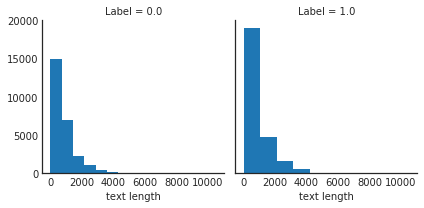

In [14]:
g = sns.FacetGrid(data,col='Label')
g.map(plt.hist,'text length')

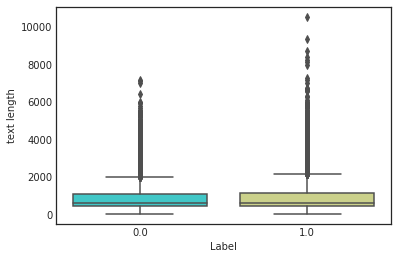

In [15]:
sns.boxplot(x='Label',y='text length',data=data,palette='rainbow')

# NLP Task

In [25]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier,AdaBoostClassifier,BaggingClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression,RidgeClassifier,Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.cross_validation import ShuffleSplit
from sklearn.grid_search import GridSearchCV
from sklearn.metrics import make_scorer,f1_score, auc
from sklearn.cross_validation import ShuffleSplit

## Using CountVectorizer method only (BOW)

In [24]:
cv = CountVectorizer()
x = data['Review']
y = data['Label']
x = cv.fit_transform(x)
x_train, x_test, y_train, y_test = train_test_split(x, y,test_size=0.2,random_state=101)
nb = RidgeClassifier(random_state=0)
nb.fit(x_train,y_train)
predictions = nb.predict(x_test)
print(confusion_matrix(y_test,predictions))
print('\n')
print(classification_report(y_test,predictions))

[[4487  750]
 [ 697 4466]]


             precision    recall  f1-score   support

        0.0       0.87      0.86      0.86      5237
        1.0       0.86      0.87      0.86      5163

avg / total       0.86      0.86      0.86     10400



##  Using Text Processing including TF-IDF

In [18]:
data_train, data_test, label_train, label_test = \
train_test_split(data['Review'], data['Label'], test_size=0.20)
print(len(data_train), len(data_test), len(data_train) + len(data_test))

41600 10400 52000


In [26]:

pipeline = Pipeline([
    ('bow', CountVectorizer()),  # strings to token integer counts
    ('tfidf', TfidfTransformer()),  # integer counts to weighted TF-IDF scores
    ('classifier', RidgeClassifier(random_state=0))
])

In [27]:
pipeline.fit(data_train,label_train)

Pipeline(memory=None,
     steps=[('bow', CountVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_...pt=True,
        max_iter=None, normalize=False, random_state=0, solver='auto',
        tol=0.001))])

In [28]:
predictions = pipeline.predict(data_test)

In [29]:
print(classification_report(predictions,label_test))

             precision    recall  f1-score   support

        0.0       0.89      0.90      0.90      5136
        1.0       0.90      0.89      0.90      5264

avg / total       0.90      0.90      0.90     10400



In [30]:
print(roc_auc_score(label_test, predictions))

0.8962849716993355
